### Basic test of classification with the new features

##### Here we investiage whether adding more features is helpful. We find that there is probably an optimal number of features to train on
##### which implies that we should do PCA

In [130]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [131]:
import DataProcess as DP
import glob
import time
import pandas as pd
from plotting_tools import plot_feature_distributions
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [132]:
protocol_datadir = '/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/'
optional_datadir = '/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Optional/'

In [133]:
allfiles = list(glob.glob(protocol_datadir+'*.dat'))+list(glob.glob(optional_datadir+'*.dat'))

all_dfs = []
for fname in allfiles:
    print(fname)
    dp = DP.dataprocess(fname)
    all_dfs.append(dp.df)
    
feature_df = pd.concat(all_dfs)

/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject101.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject102.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject103.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject104.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject105.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject106.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject107.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject108.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject109.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Optional/subject101.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2

In [137]:
activity_list = ['lying','sitting','standing','walking','running','cycling','nordic walking','watching TV',
                 'computer work','car driving','ascending stairs','descending stairs',
                  'vacuum cleaning','ironing','folding laundry','house cleaning','playing_soccer','rope jumping']
activities = pd.get_dummies(feature_df['activityID'],drop_first=True)
#activities.columns = activity_list

In [138]:
activities.head()

,2.0,3.0,4.0,5.0,6.0,7.0,9.0,10.0,11.0,12.0,13.0,16.0,17.0,18.0,19.0,20.0,24.0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [139]:
X = feature_df.drop(['activityID'],axis=1)

#### Train a random forest and looking at the feature importances

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X,activities,test_size=0.3)

In [141]:
RF = RandomForestClassifier(n_estimators=50,min_samples_split=2,min_samples_leaf=1,oob_score=True)

In [142]:
RF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [143]:
RF.oob_score_

0.9955833963857752

In [144]:
#list the most important features and their importance values
importances = RF.feature_importances_
args = np.flip(np.argsort(importances),axis=0)

In [145]:
features_to_keep = []
for i in range(10):
    arg = args[i]
    print('Feature %s. Importance: %f' %(X_train.columns[arg],importances[arg]))
    features_to_keep.append(X_train.columns[arg])

Feature hand_acc16g_x_mean. Importance: 0.029174
Feature ankle_gyro_z_std. Importance: 0.023129
Feature ankle_acc16g_x_std. Importance: 0.021912
Feature hand_acc16g_x_median. Importance: 0.021770
Feature chest_acc16g_y_std. Importance: 0.019833
Feature chest_mag_y_median. Importance: 0.019590
Feature chest_mag_y_mean. Importance: 0.018466
Feature ankle_acc16g_x_median. Importance: 0.016160
Feature ankle_acc16g_x_mean. Importance: 0.015817
Feature chest_gyro_spectrum_energy. Importance: 0.015009


In [146]:
RF.score(X_test,y_test)

0.9518828451882845

Interestingly we seem to be doing worse with all these features. This suggests that we might be overfitting and need to reduce the number of features. Lets try to see if there is an optimal number of features for our test score

In [153]:
def investigate_feature_numbers(X,Y,classifier,step_features=5,min_features=3):
    
    '''
    Train the algorithm on datasets containing decreasing numbers of features in order to
    determine if there is an optimal number of features
    '''
    
    #Start by training a random forest
    
    print("Training on all features")
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3)
    classifier.fit(X_train,y_train)
    
    train_scores = [classifier.oob_score_]
    test_scores  = [classifier.score(X_test,y_test)]
    feature_number_list = [len(X_train.columns)]
    
    #Extract just the first n features to train on. We'll extract the features in order of importance
    #to try to ensure that we get 
    
    importances = RF.feature_importances_
    args = np.flip(np.argsort(importances),axis=0)
    features_to_keep = []
    for i in range(len(X_train.columns)-step_features):
        arg = args[i]
        features_to_keep.append(X_train.columns[arg])
        
    for feature_number in np.arange(len(X.columns)-step_features,min_features,-step_features):
         
        X_new = X[features_to_keep]
        
        print("Training on %i features" %feature_number)
        
        X_train, X_test, y_train, y_test = train_test_split(X_new,Y,test_size=0.3)
        classifier.fit(X_train,y_train)
        train_scores.append(classifier.oob_score_)
        test_scores.append(classifier.score(X_test,y_test))
        feature_number_list.append(len(X_new.columns))
        
        importances = classifier.feature_importances_
        args = np.flip(np.argsort(importances),axis=0)
        features_to_keep = []
        for i in range(feature_number-step_features):
            arg = args[i]
            features_to_keep.append(X_train.columns[arg])
            
        if len(features_to_keep) < min_features:
            return test_scores, train_scores, feature_number_list
        
        

In [154]:
test_scores, train_scores, feature_numbers = investigate_feature_numbers(X,activities,RF)

Training on all features
Training on 192 features
Training on 187 features
Training on 182 features
Training on 177 features
Training on 172 features
Training on 167 features
Training on 162 features
Training on 157 features
Training on 152 features
Training on 147 features
Training on 142 features
Training on 137 features
Training on 132 features
Training on 127 features
Training on 122 features
Training on 117 features
Training on 112 features
Training on 107 features
Training on 102 features
Training on 97 features
Training on 92 features
Training on 87 features
Training on 82 features
Training on 77 features
Training on 72 features
Training on 67 features
Training on 62 features
Training on 57 features
Training on 52 features
Training on 47 features
Training on 42 features
Training on 37 features
Training on 32 features
Training on 27 features
Training on 22 features
Training on 17 features
Training on 12 features
Training on 7 features


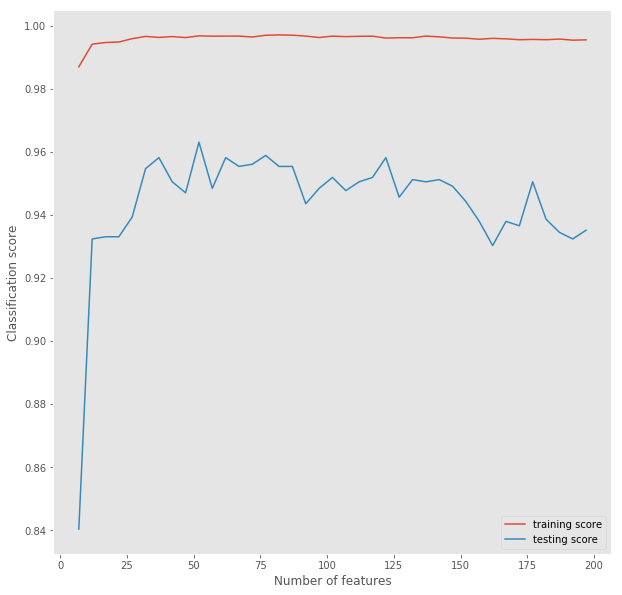

In [156]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(10,10))
plt.plot(feature_numbers,train_scores,label='training score')
plt.plot(feature_numbers,test_scores,label='testing score')
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('Classification score')
plt.grid(axis='both')